In [4]:
import os
import json
import math
import numpy as np
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.utils import save_image
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.nn.functional import one_hot

from pytorch_fid import fid_score

/tmp/ipykernel_1567/2475230352.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [8]:
transform = v2.Compose(
    [
     v2.ToTensor(),
     #v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

train_data = ImageFolder('./trafic_32', transform=transform)
train_classes = train_data.classes
train_classes = [name.lstrip('0') if name != '00000' else '0' for name in train_classes]

In [9]:
train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

In [10]:
data, classes = next(iter(train_loader))
classes[0]

tensor(11)

## GAN

In [41]:
NUBMER_OF_CLASSES = 43

In [42]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim + NUBMER_OF_CLASSES, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x, classes_encoded):
        x = torch.flatten(x, 1)
        x = torch.concat((x, classes_encoded), dim=1)

        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [76]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim + NUBMER_OF_CLASSES, hidden_dim1)
        self.fc_2 = nn.Linear(hidden_dim1, hidden_dim1)
        self.fc_3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_4 = nn.Linear(hidden_dim2, output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x, classes_encoded):
        h = torch.concat((x, classes_encoded), dim=1)

        h     = self.LeakyReLU(self.fc_1(h))
        h = self.bn1(h)
        h     = self.LeakyReLU(self.fc_2(h))
        h = self.bn2(h)
        h     = self.LeakyReLU(self.fc_3(h))
        h = self.bn3(h)


        x_hat = torch.sigmoid(self.fc_4(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [77]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim1=256, hidden_dim2=64, output_dim=3072).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=3072).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [78]:
def get_classes_encoded(train_classes: list, classes_names: list, encoding):
    return torch.stack([encoding[train_classes.index(str(name.item()))] for name in classes_names], dim=0)

In [79]:
def combine(images, encodings):
    encodings = encodings.unsqueeze(0).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    encodings = encodings.expand(254, 3, 32, 32, 43)

In [80]:
encoding = one_hot(torch.arange(0, 43), 43)

In [81]:
fixed_noise = torch.randn(8, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.134, discriminator real acc: 0.674


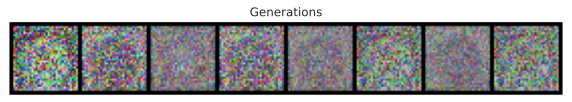

Epoch: 1, discrimiantor fake error: 0.0683, discriminator real acc: 0.829
Epoch: 2, discrimiantor fake error: 0.094, discriminator real acc: 0.852
Epoch: 3, discrimiantor fake error: 0.0883, discriminator real acc: 0.882
Epoch: 4, discrimiantor fake error: 0.0796, discriminator real acc: 0.905
Epoch: 5, discrimiantor fake error: 0.0796, discriminator real acc: 0.912
Epoch: 6, discrimiantor fake error: 0.0846, discriminator real acc: 0.911
Epoch: 7, discrimiantor fake error: 0.0838, discriminator real acc: 0.92
Epoch: 8, discrimiantor fake error: 0.0936, discriminator real acc: 0.909
Epoch: 9, discrimiantor fake error: 0.0992, discriminator real acc: 0.904
Epoch: 10, discrimiantor fake error: 0.108, discriminator real acc: 0.894


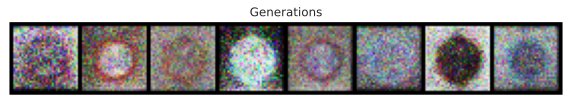

Epoch: 11, discrimiantor fake error: 0.115, discriminator real acc: 0.889
Epoch: 12, discrimiantor fake error: 0.128, discriminator real acc: 0.875
Epoch: 13, discrimiantor fake error: 0.134, discriminator real acc: 0.871
Epoch: 14, discrimiantor fake error: 0.142, discriminator real acc: 0.867
Epoch: 15, discrimiantor fake error: 0.144, discriminator real acc: 0.865
Epoch: 16, discrimiantor fake error: 0.142, discriminator real acc: 0.866
Epoch: 17, discrimiantor fake error: 0.147, discriminator real acc: 0.857
Epoch: 18, discrimiantor fake error: 0.137, discriminator real acc: 0.869
Epoch: 19, discrimiantor fake error: 0.146, discriminator real acc: 0.857
Epoch: 20, discrimiantor fake error: 0.154, discriminator real acc: 0.85


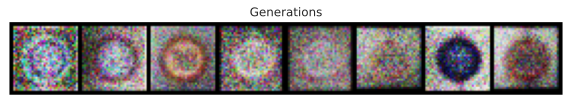

Epoch: 21, discrimiantor fake error: 0.16, discriminator real acc: 0.848
Epoch: 22, discrimiantor fake error: 0.158, discriminator real acc: 0.844
Epoch: 23, discrimiantor fake error: 0.158, discriminator real acc: 0.847
Epoch: 24, discrimiantor fake error: 0.152, discriminator real acc: 0.848
Epoch: 25, discrimiantor fake error: 0.147, discriminator real acc: 0.858
Epoch: 26, discrimiantor fake error: 0.157, discriminator real acc: 0.852
Epoch: 27, discrimiantor fake error: 0.158, discriminator real acc: 0.851
Epoch: 28, discrimiantor fake error: 0.157, discriminator real acc: 0.848
Epoch: 29, discrimiantor fake error: 0.155, discriminator real acc: 0.85
Epoch: 30, discrimiantor fake error: 0.159, discriminator real acc: 0.841


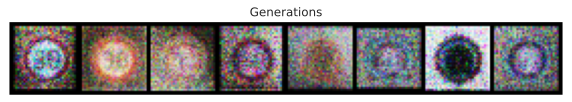

Epoch: 31, discrimiantor fake error: 0.158, discriminator real acc: 0.846
Epoch: 32, discrimiantor fake error: 0.162, discriminator real acc: 0.846
Epoch: 33, discrimiantor fake error: 0.164, discriminator real acc: 0.842
Epoch: 34, discrimiantor fake error: 0.168, discriminator real acc: 0.833
Epoch: 35, discrimiantor fake error: 0.17, discriminator real acc: 0.829
Epoch: 36, discrimiantor fake error: 0.162, discriminator real acc: 0.839
Epoch: 37, discrimiantor fake error: 0.151, discriminator real acc: 0.855
Epoch: 38, discrimiantor fake error: 0.161, discriminator real acc: 0.845
Epoch: 39, discrimiantor fake error: 0.154, discriminator real acc: 0.85
Epoch: 40, discrimiantor fake error: 0.157, discriminator real acc: 0.848


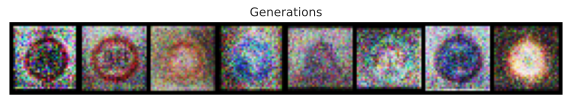

Epoch: 41, discrimiantor fake error: 0.165, discriminator real acc: 0.842
Epoch: 42, discrimiantor fake error: 0.161, discriminator real acc: 0.846
Epoch: 43, discrimiantor fake error: 0.168, discriminator real acc: 0.836
Epoch: 44, discrimiantor fake error: 0.159, discriminator real acc: 0.841
Epoch: 45, discrimiantor fake error: 0.152, discriminator real acc: 0.853
Epoch: 46, discrimiantor fake error: 0.162, discriminator real acc: 0.843
Epoch: 47, discrimiantor fake error: 0.159, discriminator real acc: 0.847
Epoch: 48, discrimiantor fake error: 0.159, discriminator real acc: 0.853
Epoch: 49, discrimiantor fake error: 0.155, discriminator real acc: 0.851
Epoch: 50, discrimiantor fake error: 0.149, discriminator real acc: 0.85


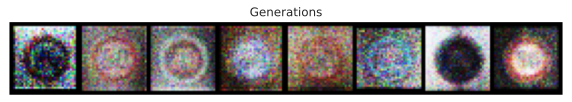

Epoch: 51, discrimiantor fake error: 0.151, discriminator real acc: 0.851
Epoch: 52, discrimiantor fake error: 0.15, discriminator real acc: 0.851
Epoch: 53, discrimiantor fake error: 0.154, discriminator real acc: 0.852
Epoch: 54, discrimiantor fake error: 0.162, discriminator real acc: 0.843
Epoch: 55, discrimiantor fake error: 0.163, discriminator real acc: 0.841
Epoch: 56, discrimiantor fake error: 0.157, discriminator real acc: 0.849
Epoch: 57, discrimiantor fake error: 0.164, discriminator real acc: 0.845
Epoch: 58, discrimiantor fake error: 0.167, discriminator real acc: 0.838
Epoch: 59, discrimiantor fake error: 0.162, discriminator real acc: 0.84
Epoch: 60, discrimiantor fake error: 0.168, discriminator real acc: 0.834


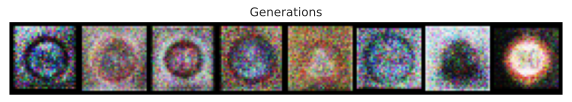

Epoch: 61, discrimiantor fake error: 0.159, discriminator real acc: 0.842
Epoch: 62, discrimiantor fake error: 0.167, discriminator real acc: 0.838
Epoch: 63, discrimiantor fake error: 0.167, discriminator real acc: 0.84
Epoch: 64, discrimiantor fake error: 0.166, discriminator real acc: 0.84
Epoch: 65, discrimiantor fake error: 0.169, discriminator real acc: 0.837
Epoch: 66, discrimiantor fake error: 0.16, discriminator real acc: 0.846
Epoch: 67, discrimiantor fake error: 0.166, discriminator real acc: 0.836
Epoch: 68, discrimiantor fake error: 0.167, discriminator real acc: 0.837
Epoch: 69, discrimiantor fake error: 0.166, discriminator real acc: 0.84
Epoch: 70, discrimiantor fake error: 0.17, discriminator real acc: 0.834


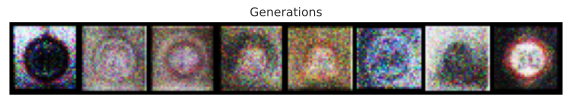

Epoch: 71, discrimiantor fake error: 0.173, discriminator real acc: 0.832
Epoch: 72, discrimiantor fake error: 0.172, discriminator real acc: 0.835
Epoch: 73, discrimiantor fake error: 0.171, discriminator real acc: 0.835
Epoch: 74, discrimiantor fake error: 0.173, discriminator real acc: 0.831
Epoch: 75, discrimiantor fake error: 0.168, discriminator real acc: 0.84
Epoch: 76, discrimiantor fake error: 0.161, discriminator real acc: 0.842
Epoch: 77, discrimiantor fake error: 0.162, discriminator real acc: 0.843
Epoch: 78, discrimiantor fake error: 0.162, discriminator real acc: 0.844
Epoch: 79, discrimiantor fake error: 0.168, discriminator real acc: 0.838
Epoch: 80, discrimiantor fake error: 0.165, discriminator real acc: 0.841


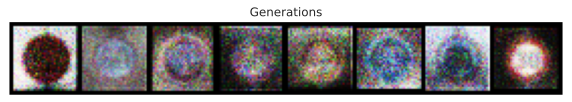

Epoch: 81, discrimiantor fake error: 0.163, discriminator real acc: 0.843
Epoch: 82, discrimiantor fake error: 0.154, discriminator real acc: 0.851
Epoch: 83, discrimiantor fake error: 0.152, discriminator real acc: 0.851
Epoch: 84, discrimiantor fake error: 0.155, discriminator real acc: 0.849
Epoch: 85, discrimiantor fake error: 0.153, discriminator real acc: 0.854
Epoch: 86, discrimiantor fake error: 0.148, discriminator real acc: 0.857
Epoch: 87, discrimiantor fake error: 0.149, discriminator real acc: 0.853
Epoch: 88, discrimiantor fake error: 0.155, discriminator real acc: 0.847
Epoch: 89, discrimiantor fake error: 0.156, discriminator real acc: 0.847
Epoch: 90, discrimiantor fake error: 0.149, discriminator real acc: 0.855


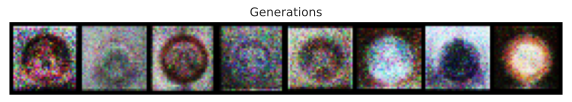

Epoch: 91, discrimiantor fake error: 0.148, discriminator real acc: 0.856
Epoch: 92, discrimiantor fake error: 0.145, discriminator real acc: 0.859
Epoch: 93, discrimiantor fake error: 0.149, discriminator real acc: 0.857
Epoch: 94, discrimiantor fake error: 0.148, discriminator real acc: 0.862
Epoch: 95, discrimiantor fake error: 0.145, discriminator real acc: 0.862
Epoch: 96, discrimiantor fake error: 0.144, discriminator real acc: 0.862
Epoch: 97, discrimiantor fake error: 0.141, discriminator real acc: 0.862
Epoch: 98, discrimiantor fake error: 0.138, discriminator real acc: 0.865
Epoch: 99, discrimiantor fake error: 0.137, discriminator real acc: 0.868


In [82]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        classes_encoded = get_classes_encoded(train_classes, data[1], encoding).to(device)
        real_images = data[0].to(device)

        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images, classes_encoded).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator

        fake_images = generator(noise, classes_encoded)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach(), classes_encoded).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D

        output = discriminator(fake_images, classes_encoded).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
   
    if epoch % 10 == 0:
        classes_encoded_small = get_classes_encoded(train_classes, [torch.tensor(1), torch.tensor(2),torch.tensor(3),torch.tensor(16),torch.tensor(23),\
                                                                torch.tensor(34),torch.tensor(8),torch.tensor(9)], encoding).to(device)
        with torch.no_grad():
            fake = generator(fixed_noise, classes_encoded_small).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

In [101]:
 for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        classes_encoded = get_classes_encoded(train_classes, data[1], encoding).to(device)
        real_images = data[0].to(device)

        b_size = real_images.size(0)
        print(b_size)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images, classes_encoded).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator

256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256


KeyboardInterrupt: 

In [83]:
def get_train_images(num):
    return torch.stack([train_data[i][0] for i in range(10,10+num)], dim=0)

In [84]:
input_imgs = get_train_images(8)

In [128]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=n_imgs, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    images, labels = next(iter(train_loader))
    # classes_to_generate = torch.concat((rmd_to_genrate, encoding[:n_imgs]), dim=1).to(device)
    # print(classes_to_generate)
    fixed_noise = torch.randn(n_imgs, 32 ,device=device).to(device)
    # rmd_to_genrate = torch.randn([12, 32]).to(device)
    encoded_classes = get_classes_encoded(train_classes, labels, encoding).to(device)
    with torch.no_grad():
        generated_imgs = model(fixed_noise, encoded_classes).to(device)
    generated_imgs = generated_imgs.cpu()


    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

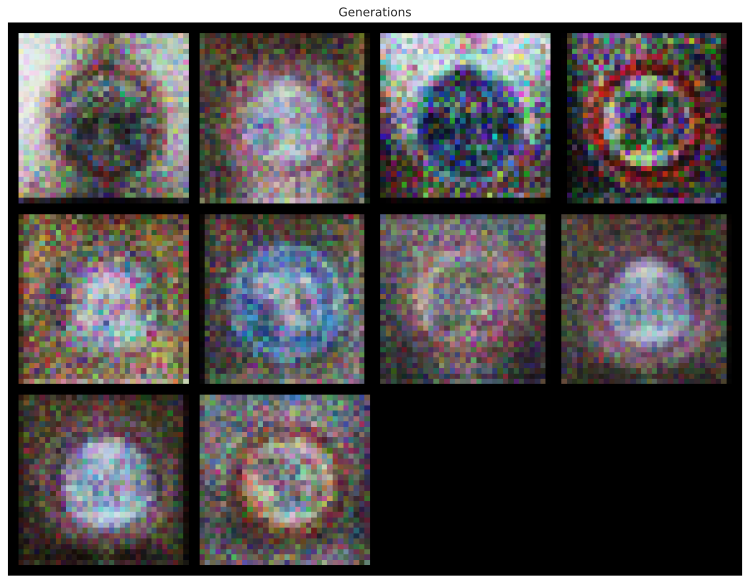

In [129]:
generate_images(generator, 10, device)

In [150]:
def im_save(img, path):
    #img = img / 2 + 0.5     # unnormalize
    save_image(img, path)

def evaluate_model(model, train_data, encoding: list, train_classes, n_imgs):
    model.eval()
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=n_imgs, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    images, labels = next(iter(train_loader))
    fixed_noise = torch.randn(n_imgs, 32 ,device=device).to(device)
    encoded_classes = get_classes_encoded(train_classes, labels, encoding).to(device)
    with torch.no_grad():
        generated_imgs = model(fixed_noise, encoded_classes).to(device)
    generated_imgs = generated_imgs.cpu()
    
    
    for j, img in enumerate(generated_imgs):
        im_save(img, f'gen_eval/img{j}.jpg')
    for j, img in enumerate(images):
        im_save(img, f'real_eval/img{j}.jpg')
    paths = ['real_eval', 'gen_eval']
    return fid_score.calculate_fid_given_paths(paths, batch_size=200, device='cuda', dims=2048)


In [151]:
evaluate_model(generator, train_data, encoding, train_classes, 256)

202.0269852090493